## **Import Image data**

In [ ]:
from src.dataset import *
from src.models import *
from src.loss import *
from src.train import *

In [ ]:
import os
import torch
import kagglehub
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


In [ ]:
# Load datasets
df_train, df_test = load_datasets()
print(df_train.head())
print(df_test.head())

## **Preprocess the data**

In [ ]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/nogaschw/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4


In [ ]:
def get_the_image(name, number):
    path_images = os.path.join(path, 'lfw-deepfunneled', 'lfw-deepfunneled')
    image_long_path = os.path.join(path_images, name)
    return os.path.join(image_long_path, f'{name}_{int(number):04d}.jpg')

In [ ]:
df_train = pd.read_csv('parsed_train.csv')
df_test = pd.read_csv('parsed_test.csv')
df_train = df_train.rename(columns={'posative_pair': 'same_person'})
df_test = df_test.rename(columns={'posative_pair': 'same_person'})

### Stats

In [ ]:
def person_pic():
    # Create a dataframe with two columns: 'name' and 'num_pic'
    person_list = []
    pic_count_list = []
    
    path_images = os.path.join(path, 'lfw-deepfunneled', 'lfw-deepfunneled')
    if os.path.isdir(path_images):
        for file in os.listdir(path_images):
            image_long_path = os.path.join(path_images, file)
            person_list.append(file)
            pic_num = 0
            for file in os.listdir(image_long_path):
                pic_num += 1
            pic_count_list.append(pic_num)

    return pd.DataFrame({'name': person_list, 'num_pic': pic_count_list})

In [ ]:
df = person_pic()
df['num_pic'].mean()

2.301791615933206

In [ ]:
df_train.columns 

Index(['name_1', 'image_1', 'name_2', 'image_2', 'same_person'], dtype='object')

In [ ]:
d = {}
for i, row in df_train.iterrows():
    name1 = row['name_1']
    name2 = row['name_2']
    if not name1 in d.keys():
        d[name1] = 0
    if not name2 in d.keys():
        d[name2] = 0
    d[name1] += 1
    d[name2] += 1

In [ ]:
d = {}
for i, row in df_test.iterrows():
    name1 = row['name_1']
    name2 = row['name_2']
    if not name1 in d.keys():
        d[name1] = 0
    if not name2 in d.keys():
        d[name2] = 0
    d[name1] += 1
    d[name2] += 1

In [ ]:
keys_with_value_10 = [key for key, value in d.items() if value == 10]
print(keys_with_value_10)

['Tang_Jiaxuan']


In [ ]:
df_test[df_test['name_2'] == 'Tang_Jiaxuan']

,name_1,image_1,name_2,image_2,same_person
451,Tang_Jiaxuan,1,Tang_Jiaxuan,6,1
452,Tang_Jiaxuan,1,Tang_Jiaxuan,9,1
453,Tang_Jiaxuan,1,Tang_Jiaxuan,10,1
454,Tang_Jiaxuan,1,Tang_Jiaxuan,11,1
907,Makhdoom_Amin_Fahim,1,Tang_Jiaxuan,5,0
992,Stefano_Gabbana,1,Tang_Jiaxuan,3,0


In [ ]:
df_test['name_2'].value_counts().sort_values()

name_2
Sam_Brownback                  1
Gwyneth_Paltrow                1
Gwendal_Peizerat               1
Gus_Van_Sant                   1
Gregory_Hines                  1
                              ..
John_Bolton                    4
Gilberto_Rodriguez_Orejuela    4
Robert_Redford                 5
Leonid_Kuchma                  5
Tang_Jiaxuan                   6
Name: count, Length: 687, dtype: int64

In [ ]:
df_test['same_person'].value_counts(), df_train['same_person'].value_counts()

(same_person
 1    500
 0    500
 Name: count, dtype: int64,
 same_person
 1    1100
 0    1100
 Name: count, dtype: int64)

In [ ]:
df_test[df_test['name_1'].apply(lambda x: x.__contains__('Abd'))]

,name_1,image_1,name_2,image_2,same_person
0,Abdullah_Gul,13,Abdullah_Gul,14,1
1,Abdullah_Gul,13,Abdullah_Gul,16,1
2,Abdullatif_Sener,1,Abdullatif_Sener,2,1
267,King_Abdullah_II,1,King_Abdullah_II,2,1
268,King_Abdullah_II,1,King_Abdullah_II,3,1
269,King_Abdullah_II,1,King_Abdullah_II,4,1
270,King_Abdullah_II,2,King_Abdullah_II,3,1
503,Abdul_Majeed_Shobokshi,1,Charles_Cope,1,0
504,Abdullah_Gul,16,Steve_Cox,1,0


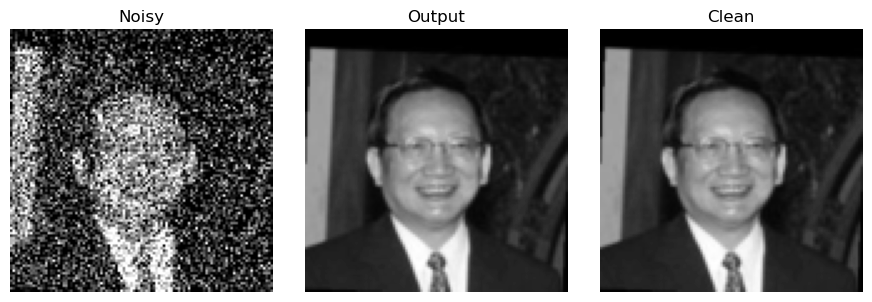

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Load image
img = Image.open(get_the_image('Tang_Jiaxuan', 1)).convert("L")  # grayscale

# Define transforms
resize = T.Resize((105, 105))
to_tensor = T.ToTensor()
add_noise = lambda x: torch.clamp(x + 0.3 * torch.randn_like(x), 0., 1.)

# Apply transforms
img_resized = resize(img)
img_clean = to_tensor(img_resized)
img_noisy = add_noise(img_clean)

# Dummy model output (for demo)
img_out = img_clean  # In practice, this would be model(img_noisy.unsqueeze(0)).squeeze(0)

# Plot
def show_triplet(noisy, out, clean):
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].imshow(noisy.squeeze(), cmap='gray'); axs[0].set_title("Noisy")
    axs[1].imshow(out.squeeze(), cmap='gray'); axs[1].set_title("Output")
    axs[2].imshow(clean.squeeze(), cmap='gray'); axs[2].set_title("Clean")
    for ax in axs: ax.axis('off')
    plt.tight_layout(); plt.show()

show_triplet(img_noisy, img_out, img_clean)


In [ ]:
# Visualize results
noisy = torch.rand((1, 105, 105))
out = torch.rand((1, 105, 105))
clean = torch.rand((1, 105, 105))
show_triplet(noisy, out, clean)

In [ ]:
# Initialize the model
model = ExampleModel()
print(model)

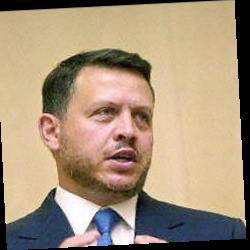

In [ ]:
Image.open(get_the_image('King_Abdullah_II', 3))

In [ ]:
# Train the model
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(torch.randn(100, 105), torch.randint(0, 2, (100,)))
dataloader = DataLoader(dataset, batch_size=10)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
train_model(model, dataloader, criterion, optimizer)

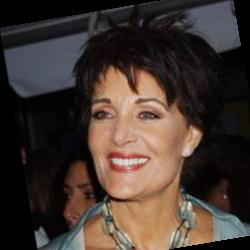

In [ ]:
Image.open(get_the_image('Linda_Dano', 1))

## **Train the model**

In [59]:
model = SiameseNetwork()

In [60]:
# Hyperparamters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100
batch_size=32
lr=1e-3
patience=5
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
model = model.to(device)

In [62]:
train_df, val_df = train_test_split(
    df_train,
    test_size=0.2,
    random_state=42,
    stratify=df_train['same_person']
)

In [63]:
l_train_loss, l_val_loss = [], []
accuracy_train, accuracy_val = [], []

In [ ]:
criterion = ContrastiveLoss()

### BCE loss

In [65]:
train_loader = DataLoader(SiameseDataset(train_df, 'gray'), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(SiameseDataset(val_df, 'gray'), batch_size=batch_size)

In [51]:
{'gray', 'gray_denoise', 'rgb', 'rgb_denoise'}

{'gray', 'gray_denoise', 'rgb', 'rgb_denoise'}

In [ ]:
train(model, criterion, train_loader, val_loader)

number of epoch: 0


100%|██████████| 55/55 [00:07<00:00,  7.52it/s]


Epoch 1: Train Loss=0.7277, Val Loss=0.7969, Train Accuracy=0.5705, Val Accuracy=0.5591
Epoch 1: lr = 0.001000
number of epoch: 1


100%|██████████| 55/55 [00:06<00:00,  8.97it/s]


Epoch 2: Train Loss=0.6470, Val Loss=0.7436, Train Accuracy=0.6080, Val Accuracy=0.6205
Epoch 2: lr = 0.001000
number of epoch: 2


100%|██████████| 55/55 [00:06<00:00,  8.93it/s]


Epoch 3: Train Loss=0.6171, Val Loss=0.6928, Train Accuracy=0.6443, Val Accuracy=0.6250
Epoch 3: lr = 0.001000
number of epoch: 3


100%|██████████| 55/55 [00:06<00:00,  8.93it/s]


Epoch 4: Train Loss=0.5556, Val Loss=0.7920, Train Accuracy=0.6960, Val Accuracy=0.6432
Epoch 4: lr = 0.001000
number of epoch: 4


100%|██████████| 55/55 [00:06<00:00,  8.77it/s]


Epoch 5: Train Loss=0.5318, Val Loss=0.9621, Train Accuracy=0.7091, Val Accuracy=0.6591
Epoch 5: lr = 0.001000
number of epoch: 5


100%|██████████| 55/55 [00:06<00:00,  8.77it/s]


Epoch 6: Train Loss=0.4712, Val Loss=1.0913, Train Accuracy=0.7523, Val Accuracy=0.6682
Epoch 6: lr = 0.001000
number of epoch: 6


100%|██████████| 55/55 [00:06<00:00,  8.93it/s]


Epoch 7: Train Loss=0.4483, Val Loss=1.0005, Train Accuracy=0.7835, Val Accuracy=0.6568
Epoch 7: lr = 0.001000
number of epoch: 7


100%|██████████| 55/55 [00:06<00:00,  8.90it/s]


Epoch 8: Train Loss=0.3991, Val Loss=1.2215, Train Accuracy=0.8119, Val Accuracy=0.6068
Epoch 8: lr = 0.001000
number of epoch: 8


100%|██████████| 55/55 [00:06<00:00,  8.56it/s]


Epoch 9: Train Loss=0.3636, Val Loss=1.1317, Train Accuracy=0.8267, Val Accuracy=0.6727
Epoch 9: lr = 0.001000
number of epoch: 9


100%|██████████| 55/55 [00:06<00:00,  8.75it/s]


Epoch 10: Train Loss=0.2920, Val Loss=1.3984, Train Accuracy=0.8756, Val Accuracy=0.6455
Epoch 10: lr = 0.001000
number of epoch: 10


100%|██████████| 55/55 [00:06<00:00,  8.87it/s]


Epoch 11: Train Loss=0.2513, Val Loss=1.3201, Train Accuracy=0.8886, Val Accuracy=0.6909
Epoch 11: lr = 0.001000
number of epoch: 11


100%|██████████| 55/55 [00:06<00:00,  8.90it/s]


Epoch 12: Train Loss=0.2386, Val Loss=1.5252, Train Accuracy=0.8983, Val Accuracy=0.6523
Epoch 12: lr = 0.001000
number of epoch: 12


100%|██████████| 55/55 [00:06<00:00,  8.79it/s]


Epoch 13: Train Loss=0.2465, Val Loss=1.3506, Train Accuracy=0.8955, Val Accuracy=0.6795
Epoch 13: lr = 0.001000
number of epoch: 13


100%|██████████| 55/55 [00:06<00:00,  8.96it/s]


Epoch 14: Train Loss=0.2124, Val Loss=1.5325, Train Accuracy=0.9114, Val Accuracy=0.6795
Epoch 14: lr = 0.001000
number of epoch: 14


100%|██████████| 55/55 [00:06<00:00,  8.92it/s]


Epoch 15: Train Loss=0.1674, Val Loss=1.8911, Train Accuracy=0.9341, Val Accuracy=0.6432
Epoch 15: lr = 0.001000
number of epoch: 15


100%|██████████| 55/55 [00:06<00:00,  8.93it/s]


Epoch 16: Train Loss=0.1611, Val Loss=1.8675, Train Accuracy=0.9301, Val Accuracy=0.6659
Early stopping triggered!


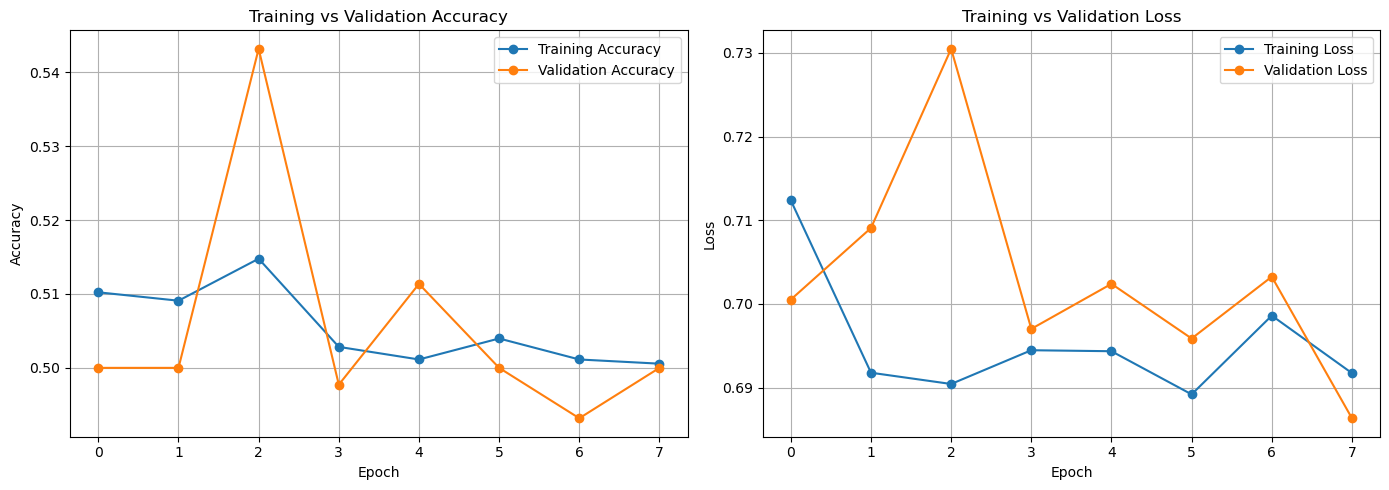

In [19]:
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(accuracy_train, marker='o', label='Training Accuracy')
plt.plot(accuracy_val, marker='o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(l_train_loss, marker='o', label='Training Loss')
plt.plot(l_val_loss, marker='o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [67]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
print("Loaded model from 'best_model.pth'")

Loaded model from 'best_model.pth'


In [70]:
test_loader = DataLoader(SiameseDataset(df_test, 'gray'), batch_size=32, shuffle=False)

In [71]:
evaluate(model,test_loader)

Confusion Matrix:
[[440  60]
 [278 222]]


{'Accuracy': 0.662,
 'ConfusionMatrix': array([[440,  60],
        [278, 222]])}